In [253]:
# much of this code is adapted from:
# https://github.com/Tony607/Keras-Trigger-Word
# https://github.com/ShawnHymel/tflite-speech-recognition

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
from pydub import AudioSegment
from keras import models as Models
from keras import layers as Layers
%matplotlib inline

In [254]:
def build_file_list(path):
    file_list = []
    for file in os.listdir(path):
        file_list.append(os.path.join(path, file))
    return file_list

In [255]:
def synthesize_sounds(num_sounds):
    
    files_noise = build_file_list('.\\sounds\\raw\\noise')
    files_positive = build_file_list('.\\sounds\\raw\\positive')
    files_negative = build_file_list('.\\sounds\\raw\\negative')
    silence = AudioSegment.silent(duration=1000);

    i = 0
    while i < num_sounds :
        # select random background noise
        random_index = random.randrange(len(files_noise))
        raw_noise = AudioSegment.from_file(files_noise[random_index])
        # discard if background is shorter than 1000ms
        if(len(raw_noise) < 1000) : continue
        # randomly choose a 1000ms slice from the background
        slice_index = random.randrange(len(raw_noise) - 1000)
        raw_noise = raw_noise[slice_index:slice_index+1000]

        # select random positive 
        random_index = random.randrange(len(files_positive))
        raw_positive = AudioSegment.from_file(files_positive[random_index])
        # discard if raw_positive is greater than 1000ms
        if(len(raw_positive) > 1000) : continue

        # select random negative
        random_index = random.randrange(len(files_negative))
        raw_negative = AudioSegment.from_file(files_negative[random_index])
        # discard if raw_negative is greater than 1000ms
        if(len(raw_positive) > 1000): continue

        # randomly choose an insert point for the raw_positive
        insert_index = random.randrange(1000-len(raw_positive))
        positive_noisy = raw_noise.overlay(raw_positive, position=insert_index)
        positive_clean = silence.overlay(raw_positive, position=insert_index)

        #randomly choose an insert point for the raw_negative
        insert_index = random.randrange(1000-len(raw_negative) + 1)
        negative_noisy = raw_noise.overlay(raw_negative, position=insert_index)
        negative_clean = silence.overlay(raw_negative, position=insert_index)

        # export synthesized audio files
        positive_noisy.export('./sounds/synthesized/positive/positive_noisy_' + str(i) + '.wav', format='wav')
        positive_clean.export('./sounds/synthesized/positive/positive_clean_' + str(i) + '.wav', format='wav')
        negative_noisy.export('./sounds/synthesized/negative/negative_noisy_' + str(i) + '.wav', format='wav')
        negative_clean.export('./sounds/synthesized/negative/negative_clean_' + str(i) + '.wav', format='wav')
        
        
        i = i+1
    
synthesize_sounds(5000)

In [256]:
def calc_mfcc(path):
    resample_rate = 10000
    signal =  AudioSegment.from_wav(path).set_channels(1).set_frame_rate(resample_rate)
    signal = np.array(signal.get_array_of_samples())
    #sd.play(signal, resample_rate)
    mfcc = python_speech_features.base.mfcc(signal, samplerate=resample_rate, winstep=0.025, numcep=13, winfunc=np.hanning)
    mfcc = np.int8(mfcc)
    return mfcc.transpose()

path_list=build_file_list('./sounds/synthesized/negative/')
mfcc= calc_mfcc(path_list[5])

print(path_list[10])
print(mfcc.shape)
print(type(mfcc), type(mfcc[1][1]))
print(mfcc)
max(mfcc[6])


./sounds/synthesized/negative/negative_clean_1006.wav
(13, 40)
<class 'numpy.ndarray'> <class 'numpy.int8'>
[[-36 -36 -36 -36 -36 -36 -36 -36   5   6  13  16  19  19  20  20  19  16
   15  15  18  19  19  18  18  17  14  13  11  10   5 -36 -36 -36 -36 -36
  -36 -36 -36 -36]
 [  0   0   0   0   0   0   0   0 -18  -9  35  30  17   1  -7  -6   0   7
    0  -7   9  19  25  24  19  18  11   5   2   2 -14   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0  -5  -2   6   0 -21 -23 -21 -20 -24 -17
   -6 -11 -26 -35 -35 -33 -25 -30 -21 -21 -32 -30 -17   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0 -12  -3 -18 -52 -33  -4   8   3  10   3
    2   2  -7 -10 -17 -15 -21  -9  -1  11   9 -12 -19   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0  -3   5 -10   9  25   4 -32 -38 -32  -7
    0  10   9   6  10  13   4   3  14  14   7   7 -23   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0  -4   9 -13  25   9 -29

21

In [257]:
# create data sets
X = []
y = []

for positive_file in build_file_list('./sounds/synthesized/positive'):
    mfcc = calc_mfcc(positive_file)
    X.append(mfcc)
    y.append(1)

for negative_file in build_file_list('./sounds/synthesized/negative'):
    mfcc = calc_mfcc(negative_file)
    X.append(mfcc)
    y.append(0)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(20000, 13, 40) (20000,)


In [258]:
# shuffle data
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

0


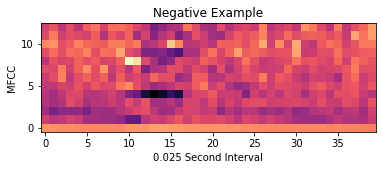

In [279]:
# sanity check
index = 100
fig = plt.figure()
plt.imshow(X[index], origin='lower', cmap="magma")
label = "Positive" if y[index] else "Negative"
plt.xlabel('0.025 Second Interval')
plt.ylabel('MFCC')
plt.title( label + ' Example')

print(y[index])

In [260]:
# create train, val, and test sets

def split_into_sets(X, y):
    length_X = len(X)
    length_train = int(0.8*length_X)
    length_val = int(0.1*length_X)
    length_test = int(0.1*length_X)

    X_train = X[:length_train]
    X_val = X[length_train:length_train+length_val]
    X_test= X[length_train+length_val:]
    y_train = y[:length_train]
    y_val = y[length_train:length_train+length_val]
    y_test= y[length_train+length_val:]

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_into_sets(X,y)


In [261]:
# reshape X_train with batch size
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [262]:

shape = X_train[0].shape

M_input = Models.Input(shape=shape)
M = Layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu')(M_input)
M = Layers.MaxPooling2D(pool_size=(2, 2), padding='same')(M)
M = Layers.Conv2D(32, (2, 2), activation='relu')(M)
M = Layers.MaxPooling2D(pool_size=(2, 2), padding='same')(M)
M = Layers.Conv2D(32, (2, 2), activation='relu')(M)
M = Layers.MaxPooling2D(pool_size=(2, 2), padding='same')(M)
M = Layers.Flatten()(M)
M = Layers.Dense(16, activation='relu')(M)
M = Layers.Dropout(0.5)(M)
M = Layers.Dense(1, activation='sigmoid')(M)

model = Models.Model(inputs=M_input, outputs=M, name="Smithers")
model.summary()


Model: "Smithers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 13, 40, 1)]       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 12, 39, 32)        160       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 6, 20, 32)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 5, 19, 32)         4128      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 3, 10, 32)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 2, 9, 32)          4128      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 1, 5, 32)          0  

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_dtype=True, dpi=100)

In [263]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [264]:
history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/30
160/160 [==============================] - 4s 17ms/step - loss: 0.4537 - acc: 0.7826 - val_loss: 0.1612 - val_acc: 0.9590
Epoch 2/30
160/160 [==============================] - 3s 18ms/step - loss: 0.1940 - acc: 0.9269 - val_loss: 0.0718 - val_acc: 0.9805
Epoch 3/30
160/160 [==============================] - 2s 15ms/step - loss: 0.1387 - acc: 0.9521 - val_loss: 0.0741 - val_acc: 0.9735
Epoch 4/30
160/160 [==============================] - 2s 15ms/step - loss: 0.1117 - acc: 0.9633 - val_loss: 0.0403 - val_acc: 0.9855
Epoch 5/30
160/160 [==============================] - 2s 15ms/step - loss: 0.0989 - acc: 0.9693 - val_loss: 0.0445 - val_acc: 0.9830
Epoch 6/30
160/160 [==============================] - 4s 28ms/step - loss: 0.0855 - acc: 0.9727 - val_loss: 0.0386 - val_acc: 0.9860
Epoch 7/30
160/160 [==============================] - 4s 23ms/step - loss: 0.0775 - acc: 0.9755 - val_loss: 0.0292 - val_acc: 0.9900
Epoch 8/30
160/160 [==============================] - 2s 14ms/step - 

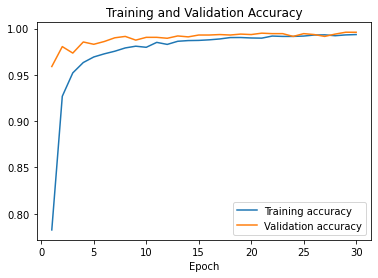

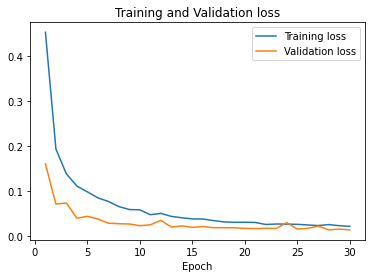

In [265]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,  label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [266]:
loss, acc = model.evaluate(x=X_test, y=y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.0147 - acc: 0.9960


In [267]:
# prediction testing
for i in range(200, 220):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(X_test[i], 0)))

Answer: 0  Prediction: [[6.1380384e-10]]
Answer: 0  Prediction: [[4.8219692e-20]]
Answer: 1  Prediction: [[0.9999846]]
Answer: 1  Prediction: [[1.]]
Answer: 0  Prediction: [[6.96268e-05]]
Answer: 0  Prediction: [[2.5176017e-20]]
Answer: 1  Prediction: [[0.9999682]]
Answer: 1  Prediction: [[0.99608266]]
Answer: 0  Prediction: [[2.1055073e-15]]
Answer: 1  Prediction: [[1.]]
Answer: 0  Prediction: [[6.502824e-07]]
Answer: 1  Prediction: [[0.99999905]]
Answer: 1  Prediction: [[1.]]
Answer: 1  Prediction: [[1.]]
Answer: 0  Prediction: [[1.10979556e-07]]
Answer: 1  Prediction: [[1.]]
Answer: 0  Prediction: [[1.6322045e-14]]
Answer: 0  Prediction: [[2.8387431e-08]]
Answer: 1  Prediction: [[0.99962115]]
Answer: 0  Prediction: [[5.538398e-13]]


[[1.]]
(13, 40)


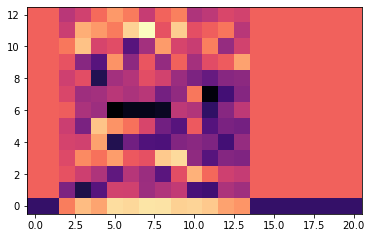

In [268]:
silence = AudioSegment.silent(duration=1000, frame_rate=10000);

def test_clip(path):
    sr =10000
    signal2 = AudioSegment.from_file(path, format='wav', channels=1)
    signal2 = AudioSegment.set_channels(signal2, 1)
    signal2 = silence.overlay(signal2)
    signal2 = AudioSegment.set_frame_rate(signal2, sr)
    signal2 = np.array(signal2.get_array_of_samples())
    mfcc = python_speech_features.base.mfcc(signal2, samplerate=sr, winstep=0.025, numcep=13, winfunc=np.hanning)
    return mfcc.transpose()


mfcc = test_clip('./sounds/synthesized/positive/positive_clean_1.wav')
out = model.predict(np.expand_dims(mfcc, 0))
print(out)

fig = plt.figure()
plt.imshow(mftt, origin='lower', cmap="magma")
print(mfcc.shape)


In [269]:
Models.save_model(model, './smithers_model')

INFO:tensorflow:Assets written to: ./smithers_model\assets


In [270]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('./smithers_model')
smithers_lite = converter.convert()

# Save the model.
with open('smithers_lite.tflite', 'wb') as f:
  f.write(smithers_lite)